In [23]:
import re 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import sqlite3
sns.set_style("whitegrid")
import matplotlib
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
from op import FleetSizeOptimizer
os.chdir('../')

In [2]:
fleetsize_07 = []
for month in range(1, 13):
    for day in range(1, 32):
        if (month == 2 and day > 28) or ((month in [4, 6, 9, 11]) and day > 30):
            continue  # Skip invalid date
        try:
            with open(f'output/demand_variation/fleet_op_result/alpha_7_demand_500/{month}_{day}_fleetsize.txt'.format(month, day), 'r') as f:
                fleetsize_07.append(int(float(re.search(r'\d+(\.\d+)?', f.readline())[0])))
        
            # with open(f'output/demand_variation/fleet_op_result/alpha_7_demand_500/{month}_{day}_fleetsize.txt'.format(month, day), 'r') as f:
            #     fleet_i = int(float(re.search(r'\d+(\.\d+)?', f.readline())[0]))

            # if fleet_i == 7:
            #     df  = pd.read_csv(f'input/demand_variation/passenger_arrival/alpha_7_demand_500/{month}_{day}.csv')
            #     df.to_csv(f'for_emin/passenger_arrival_demand_500_{month}_{day}.csv', index=False)
        
        except FileNotFoundError:
            continue

fleetsize_07 = np.array(fleetsize_07)


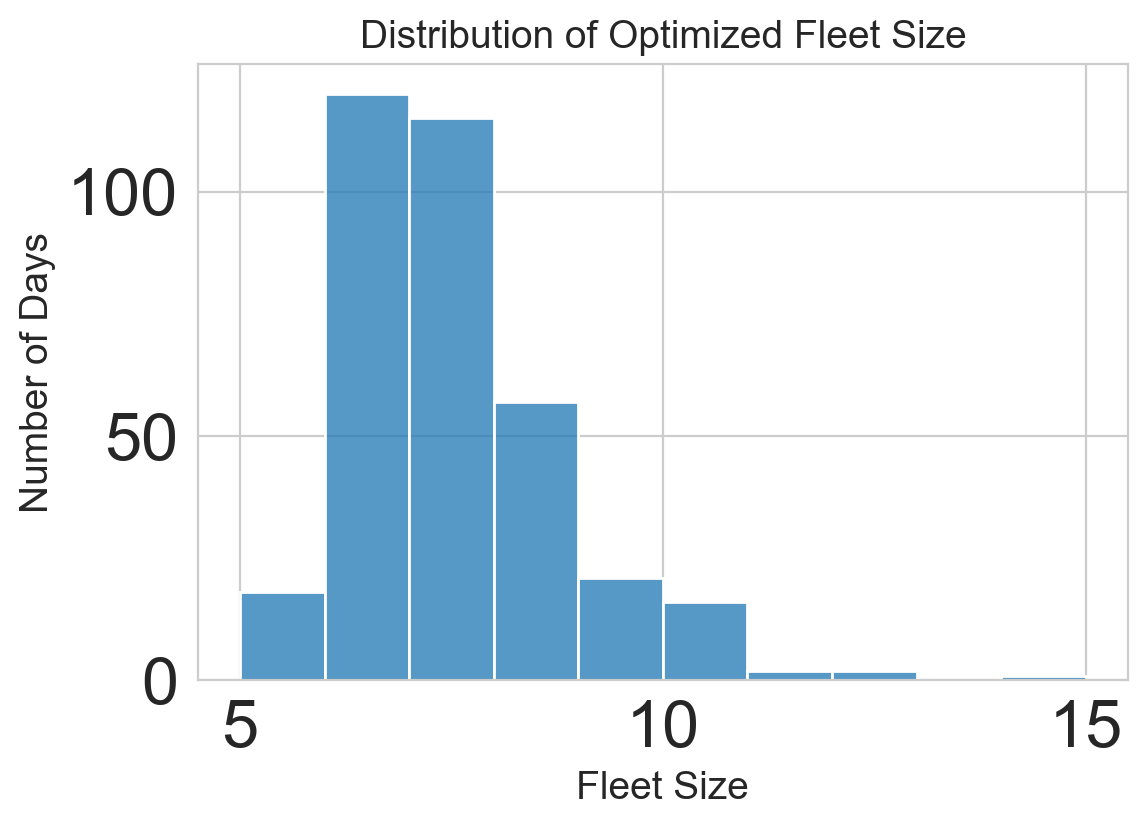

In [3]:
fig, ax = plt.subplots(figsize=(6,4), dpi=200)
sns.histplot(fleetsize_07, binwidth=1, ax=ax)
ax.set(xlabel='Fleet Size', ylabel='Number of Days', title='Distribution of Optimized Fleet Size');

In [4]:
file_list = os.listdir('output/demand_variation/fleet_op_result/alpha_7_demand_500')
all_files = []
for filename in file_list:
    if filename.endswith('_op_result.txt'):
        all_files.append(filename)


conn = sqlite3.connect('result_alpha_7_pax_500.sqlite')
for i in range(len(all_files)):
    # Load parameters
    run_id = all_files[i].split('_op_result.txt')[0]

    flight_time = np.array([[0, 10],[10, 0]]).astype(int)
    energy_consumption = np.array([[0, 10],[10, 0]]).astype(int)
    flight_distance = np.array([[0, 10],[10, 0]]).astype(int)

    # Call optimizer class and redner summary
    optimizer = FleetSizeOptimizer(flight_time, energy_consumption, schedule=f'demand_variation/schedule/alpha_7_demand_500/{run_id}.csv')
    result_path = f'demand_variation/fleet_op_result/alpha_7_demand_500/{run_id}_op_result.txt'
    optimizer.parse_result(result_path)
    optimizer.calculate_aircraft_states()
    summary = optimizer.get_summary_statistics(flight_distance, return_summary=True)

    # Save summary statistics
    line_i = np.array([summary['fleet_size'], summary['pads'][0], summary['pads'][1], summary['number_of_repositioning_flights']])
    summary_statistics = pd.DataFrame(line_i.reshape(1,4), columns=['fleet_size', 'pads_at_SFO', 'pads_at_SJC', 'number_of_repositioning_flights'])
    summary_statistics['id'] = run_id
    summary_statistics.to_sql('op_summary_statistics', conn, if_exists='append', index=False)

    # Save vertisim inputs
    vertisim_input = pd.concat([optimizer.specificc, optimizer.specificn, optimizer.specificu])
    vertisim_input.reset_index(drop=True, inplace=True)
    vertisim_input['id'] = run_id
    vertisim_input.to_sql('vertisim_input', conn, if_exists='append', index=False)



Fleet size: 7.0
Total number of pads: 11; [4 7] 
Total number of flights: 412.0; demand: 335.0; repositioning: 77.0
Total energy consumption: 1648.0 kWh
Total aircraft miles: 4120.0 mi
Total revenue aircraft miles: 3350.0
Ratio of revenue aircraft miles to aircraft miles: 0.8131067961165048
Fleet size: 6.0
Total number of pads: 9; [4 5] 
Total number of flights: 402.0; demand: 337.0; repositioning: 65.0
Total energy consumption: 1608.0 kWh
Total aircraft miles: 4020.0 mi
Total revenue aircraft miles: 3370.0
Ratio of revenue aircraft miles to aircraft miles: 0.8383084577114428
Fleet size: 7.0
Total number of pads: 12; [6 6] 
Total number of flights: 482.0; demand: 365.0; repositioning: 117.0
Total energy consumption: 1928.0 kWh
Total aircraft miles: 4820.0 mi
Total revenue aircraft miles: 3650.0
Ratio of revenue aircraft miles to aircraft miles: 0.7572614107883817
Fleet size: 7.0
Total number of pads: 12; [5 7] 
Total number of flights: 420.0; demand: 352.0; repositioning: 68.0
Total en

In [5]:

conn = sqlite3.connect('result_alpha_7_pax_500.sqlite')
query = """
SELECT *
FROM op_summary_statistics
"""
df = pd.read_sql_query(query, conn)
df



# Start here

In [2]:
import re 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import sqlite3
import matplotlib
from op import FleetSizeOptimizer
import warnings
os.chdir('../')

In [3]:
warnings.filterwarnings('ignore')
plt.style.use("seaborn-white")
sns.set_style('ticks')
color_platte = ['#93003a', '#00429d', '#93c4d2']
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.grid'] = False

### Passenger Demand Number

In [4]:
files = os.listdir('input/demand_variation/passenger_arrival/alpha_7_demand_1500/')
num_pax_1500 = []
for i in files:
    df = pd.read_csv('input/demand_variation/passenger_arrival/alpha_7_demand_1500/'+i).shape[0]
    num_pax_1500.append(df)

files = os.listdir('input/demand_variation/passenger_arrival/alpha_7_demand_2500/')
num_pax_2500 = []
for i in files:
    df = pd.read_csv('input/demand_variation/passenger_arrival/alpha_7_demand_2500/'+i).shape[0]
    num_pax_2500.append(df)

files = os.listdir('input/demand_variation/passenger_arrival/alpha_7_demand_500/')
num_pax_500 = []
for i in files:
    df = pd.read_csv('input/demand_variation/passenger_arrival/alpha_7_demand_500/'+i).shape[0]
    num_pax_500.append(df)

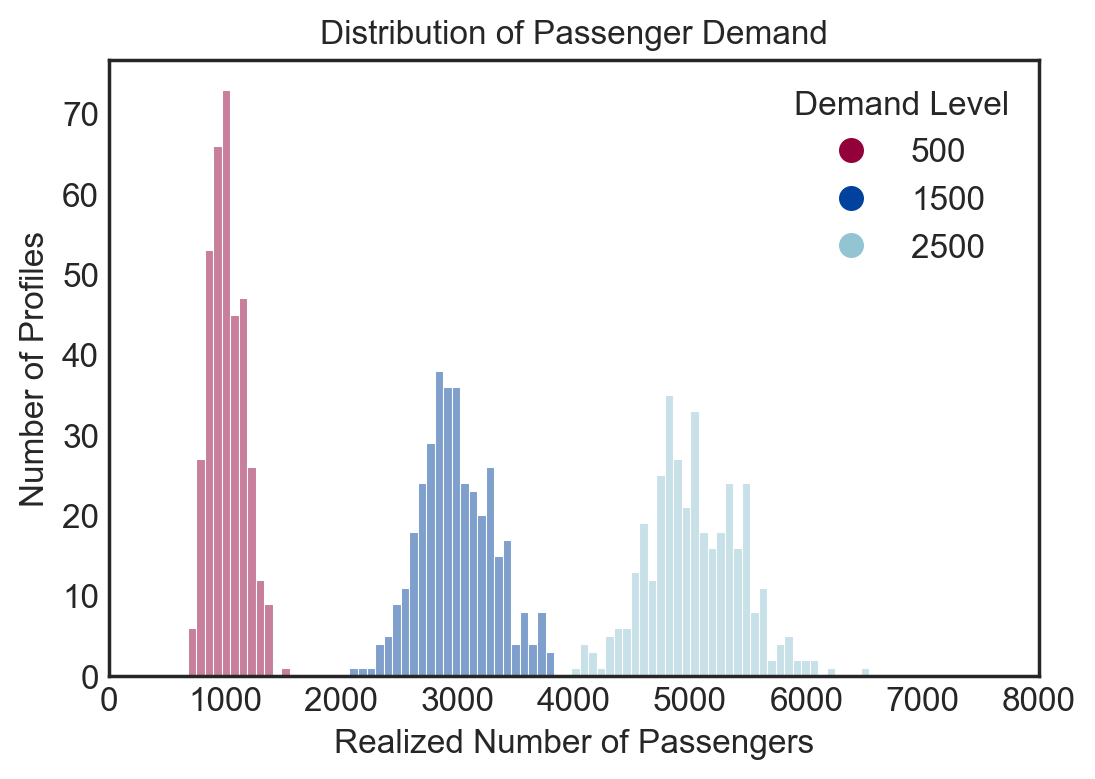

In [5]:
pax_distribution = pd.DataFrame({'pax_num':num_pax_500+num_pax_1500+num_pax_2500, 
                                 'demand_level':np.concatenate([np.repeat(500, len(num_pax_500)),
                                                                np.repeat(1500, len(num_pax_1500)), 
                                                                np.repeat(2500, len(num_pax_2500))])})
fig, ax = plt.subplots(figsize=(6,4), dpi=200)
sns.histplot(data=pax_distribution, x='pax_num', hue='demand_level', palette=color_platte, ax=ax, bins=80)
ax.set(xlabel='Realized Number of Passengers', ylabel='Number of Profiles', title='Distribution of Passenger Demand',
       xlim=(0, 8000))

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_platte[i], markersize=10) for i in range(3)]
labels = ['500', '1500', '2500']
ax.legend(handles, labels, title='Demand Level', loc='upper right');

## Fleet Size Distribution

In [6]:
def get_fleet_size(demand):
    fleetsize = []
    for month in range(1, 13):
        for day in range(1, 32):
            if (month == 2 and day > 28) or ((month in [4, 6, 9, 11]) and day > 30):
                continue  # Skip invalid date
            try:
                with open(f'output/demand_variation/fleet_op_result/alpha_7_demand_{demand}/{month}_{day}_fleetsize.txt'.format(month, day), 'r') as f:
                    fleetsize.append(int(float(re.search(r'\d+(\.\d+)?', f.readline())[0])))
            except FileNotFoundError:
                continue
    return fleetsize

In [7]:
fleetsize_500 = get_fleet_size(500)
fleetsize_1500 = get_fleet_size(1500)
fleetsize_2500 = get_fleet_size(2500)

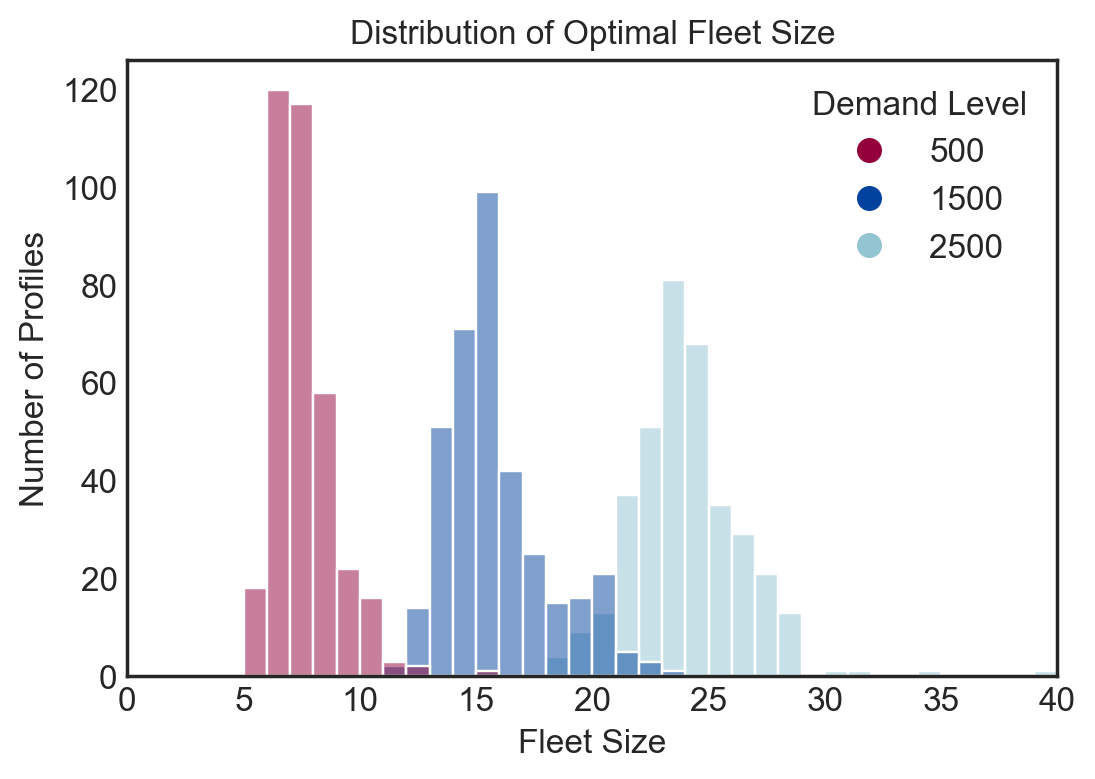

In [8]:
fleetsize_df = pd.DataFrame({'fleetsize':fleetsize_500+fleetsize_1500+fleetsize_2500, 'demand_level':np.concatenate([np.repeat(500, len(fleetsize_500)), np.repeat(1500, len(fleetsize_1500)), np.repeat(2500, len(fleetsize_2500))])}) 
fig, ax = plt.subplots(figsize=(6,4), dpi=200)
sns.histplot(data=fleetsize_df, x='fleetsize', hue='demand_level', palette=color_platte, ax=ax, bins=100, binwidth=1)
ax.set(xlim=(0, 40), xlabel='Fleet Size', ylabel='Number of Profiles', title='Distribution of Optimal Fleet Size')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_platte[i], markersize=10) for i in range(3)]
labels = ['500', '1500', '2500']
ax.legend(handles, labels, title='Demand Level', loc='upper right');

## Spill Distribution

In [9]:
def get_spill(demand):
    spill_list = []
    fleetsize_list = []

    files = os.listdir(f'output/demand_variation/spill_op_result/alpha_7_demand_{demand}')
    all_files = [file for file in files if file.endswith('_total_spill.txt')]
    file_names = np.empty(shape=(0, 3))
    for i in all_files:
        file_names = np.vstack((file_names, np.array(i.split('_')[:3])))

    # 8-15  for 500
    # 15-25 for 1500
    # 25(27)-40 for 2500

    for i in range(file_names.shape[0]):
        with open(f'output/demand_variation/spill_op_result/alpha_7_demand_{demand}/'+all_files[i], 'r') as f:
            spill = float(f.readline().split(': ')[1])
        spill_list.append(spill)
        fleetsize_list.append(int(file_names[i,2]))

    return pd.DataFrame({'fleetsize':fleetsize_list, 'spill':spill_list, 'demand_level':np.repeat(demand, len(spill_list))})

In [10]:
spill_500 = get_spill(500)
spill_1500 = get_spill(1500)
spill_2500 = get_spill(2500)

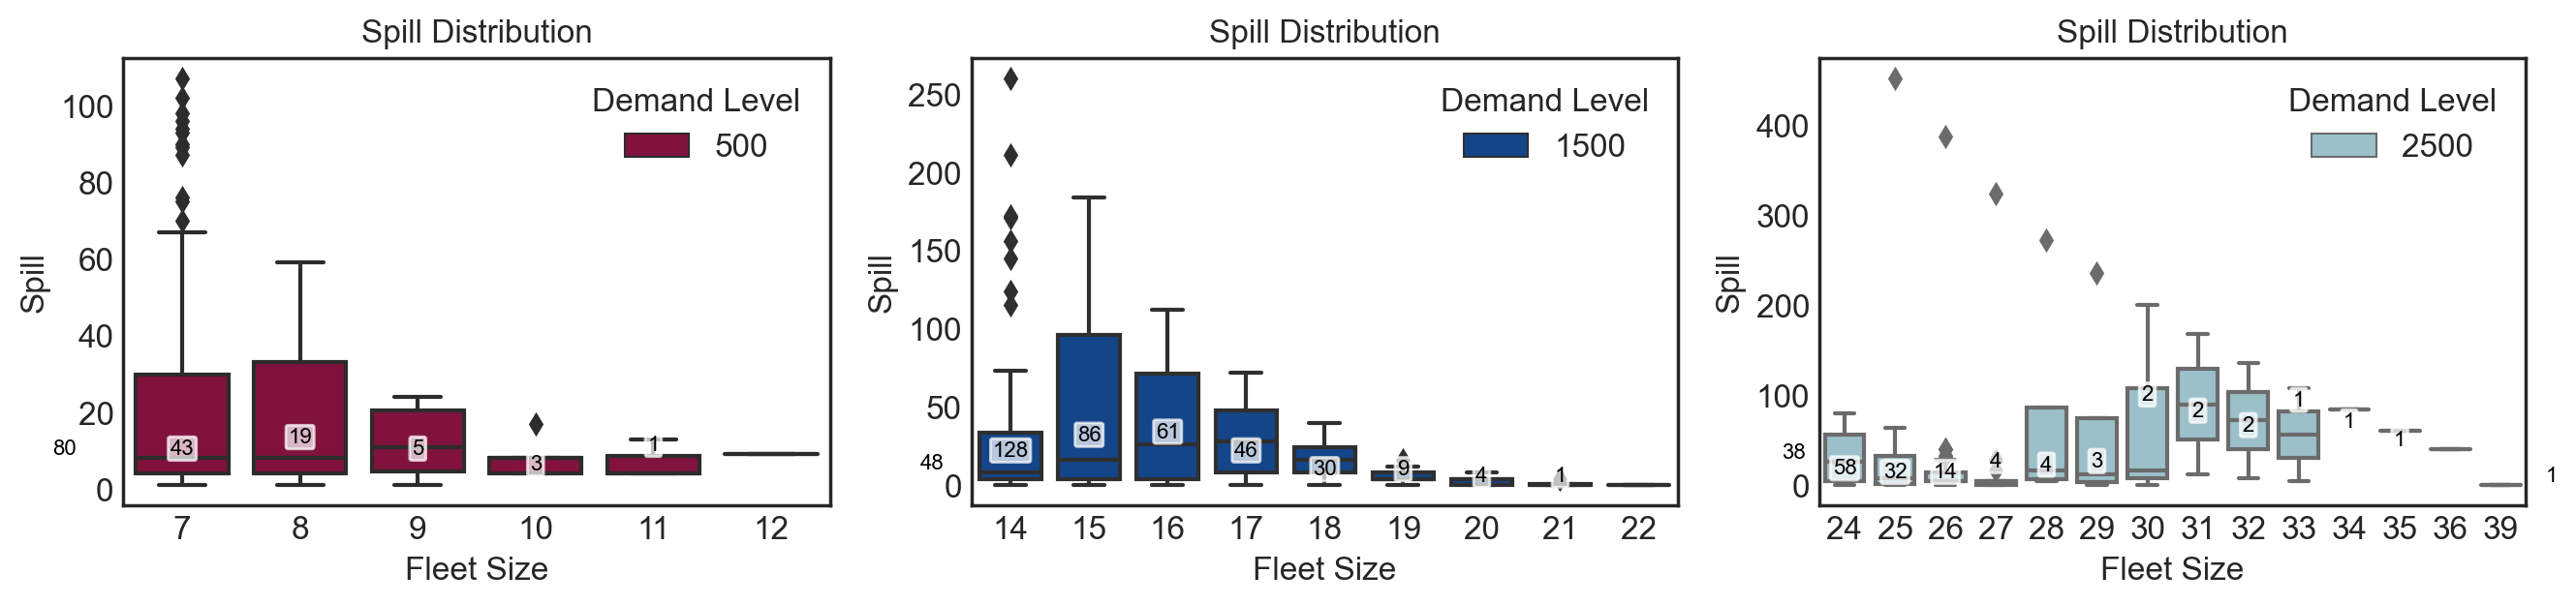

In [11]:
median = spill_500.groupby(['fleetsize', 'demand_level']).median().reset_index()
count = spill_500.groupby(['fleetsize', 'demand_level']).count().reset_index()

fig, ax = plt.subplots(ncols=3, figsize=(16, 3), dpi=200)
sns.boxplot(data=spill_500, x='fleetsize', y='spill', hue='demand_level', width=0.8, ax=ax[0], palette=color_platte)
ax[0].set(xlabel='Fleet Size', ylabel='Spill', title='Spill Distribution')

for index, row in median.iterrows():
    x_coord = row['fleetsize'] - 8 
    y_coord = row['spill']
    count_val = count[(count['fleetsize'] == row['fleetsize']) & (count['demand_level'] == row['demand_level'])]['spill'].values[0]
    ax[0].text(x_coord, y_coord, str(count_val), color='black', ha='center', va='bottom', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, boxstyle='round', pad=0.1))

ax[0].legend(title='Demand Level', loc='upper right')

median = spill_1500.groupby(['fleetsize', 'demand_level']).median().reset_index()
count = spill_1500.groupby(['fleetsize', 'demand_level']).count().reset_index()
sns.boxplot(data=spill_1500, x='fleetsize', y='spill', hue='demand_level', width=0.8, ax=ax[1], palette=color_platte[1:])
ax[1].set(xlabel='Fleet Size', ylabel='Spill', title='Spill Distribution')

for index, row in median.iterrows():
    x_coord = row['fleetsize'] - 15
    y_coord = row['spill']
    count_val = count[(count['fleetsize'] == row['fleetsize']) & (count['demand_level'] == row['demand_level'])]['spill'].values[0]
    ax[1].text(x_coord, y_coord, str(count_val), color='black', ha='center', va='bottom', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, boxstyle='round', pad=0.1))

ax[1].legend(title='Demand Level', loc='upper right')

median = spill_2500.groupby(['fleetsize', 'demand_level']).median().reset_index()
count = spill_2500.groupby(['fleetsize', 'demand_level']).count().reset_index()
sns.boxplot(data=spill_2500, x='fleetsize', y='spill', hue='demand_level', width=0.8, ax=ax[2], palette=color_platte[2:])
ax[2].set(xlabel='Fleet Size', ylabel='Spill', title='Spill Distribution')

for index, row in median.iterrows():
    x_coord = row['fleetsize'] - 25
    y_coord = row['spill']
    count_val = count[(count['fleetsize'] == row['fleetsize']) & (count['demand_level'] == row['demand_level'])]['spill'].values[0]
    ax[2].text(x_coord, y_coord, str(count_val), color='black', ha='center', va='bottom', fontsize=8, bbox=dict(facecolor='white', alpha=0.7, boxstyle='round', pad=0.1))

ax[2].legend(title='Demand Level', loc='upper right')


## Compare to the queueing system

In [109]:
from tqdm import tqdm
import importlib
import model.queueing_model
importlib.reload(model.queueing_model)
from model.queueing_model import *

In [12]:
def upper_lower_bound(demand, input_range):

    upper_bound = np.zeros(input_range[1]-input_range[0])
    lower_bound = np.zeros(input_range[1]-input_range[0])

    for month in tqdm(range(1, 13)):
        for day in range(1, 32):
            if (month == 2 and day > 28) or ((month in [4, 6, 9, 11]) and day > 30):
                continue  # Skip invalid dates
            else:
                try:
                    with open(f'output/demand_variation/fleet_op_result/alpha_7_demand_{demand}/{month}_{day}_fleetsize.txt'.format(month, day), 'r') as f:
                        fleetsize = int(float(re.search(r'\d+(\.\d+)?', f.readline())[0]))
                

                    for i in range(input_range[0], input_range[1]):
                        if fleetsize > i:
                            s = system(i, f'input/demand_variation/schedule/alpha_7_demand_{demand}/num_pax_{month}_{day}.csv', 
                                        f'input/demand_variation/schedule/alpha_7_demand_{demand}/{month}_{day}.csv')
                            upper_bound[i-input_range[0]] += s.logger(True)

                            s2 = one_vertiport_system(i, f'input/demand_variation/schedule/alpha_7_demand_{demand}/num_pax_{month}_{day}.csv', 
                                                        f'input/demand_variation/schedule/alpha_7_demand_{demand}/{month}_{day}.csv')
                            lower_bound[i-input_range[0]] += s2.logger(True)
                except FileNotFoundError:
                    continue
    return upper_bound, lower_bound    

In [184]:
from datetime import datetime

start_date = datetime(2019, 1, 1)
end_date = datetime(2019, 8, 15)
days_difference = (end_date - start_date).days

print(days_difference)
fleetsize_1500[225]

226


16

In [106]:
a = one_vertiport_system(11, 'input/demand_variation/schedule/alpha_7_demand_1500/num_pax_8_15.csv', 'input/demand_variation/schedule/alpha_7_demand_1500/8_15.csv', print_log=True)

In [107]:
a.logger(True)

------------------------------------------timestep------------------------------------------
Aircraft AA00 soc 80, delay 0
Aircraft AA01 soc 80, delay 0
Aircraft AA02 soc 80, delay 0
Aircraft AA03 soc 80, delay 0
Aircraft AA04 soc 80, delay 0
Aircraft AA05 soc 80, delay 0
Aircraft AA06 soc 80, delay 0
Aircraft AA07 soc 80, delay 0
Aircraft AA08 soc 80, delay 0
Aircraft AA09 soc 80, delay 0
Aircraft AA10 soc 80, delay 0
Number of aircraft avalibale: 11
Flight demand: 1
AA00 dispatched for flight 70
NUmber of aircraft departed: 1
4 [4]
------------------------------------------timestep------------------------------------------
Aircraft AA00 soc 70, delay 1
Aircraft AA01 soc 80, delay 0
Aircraft AA02 soc 80, delay 0
Aircraft AA03 soc 80, delay 0
Aircraft AA04 soc 80, delay 0
Aircraft AA05 soc 80, delay 0
Aircraft AA06 soc 80, delay 0
Aircraft AA07 soc 80, delay 0
Aircraft AA08 soc 80, delay 0
Aircraft AA09 soc 80, delay 0
Aircraft AA10 soc 80, delay 0
Number of aircraft avalibale: 10
Flig

47.0

In [30]:
soc_transition_time

array([ 0.774,  0.798,  0.822,  0.852,  0.882,  0.918,  0.948,  0.996,
        1.032,  1.08 ,  1.128,  1.182,  1.242,  1.314,  1.386,  1.47 ,
        1.56 ,  1.668,  1.8  ,  1.938,  2.106,  2.304,  2.538,  2.832,
        3.216,  3.702,  4.356,  5.322,  6.816,  9.492, 15.732, 55.668])

In [32]:
u

0

In [36]:
soc_transition_time = np.array([0.0129,0.0133,0.0137,0.0142,0.0147,
                                0.0153,0.0158,0.0166,0.0172,0.018,
                                0.0188,0.0197,0.0207,0.0219,0.0231,
                                0.0245,0.026,0.0278,0.03,0.0323,
                                0.0351,0.0384,0.0423,0.0472,0.0536,
                                0.0617,0.0726,0.0887,0.1136,0.1582,
                                0.2622,0.9278,])*60

w = []
for i in range(len(soc_transition_time)):
    idx = i
    cnt = 0
    while soc_transition_time[i:idx+1].sum() <= 5:
        idx += 1
        cnt += 1
    
    w.append(cnt)
np.array(w)

array([5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [41]:
15//2.5

6.0

In [110]:
# ub_2500, lb_2500 = upper_lower_bound(2500, [20,40])
ub_1500, lb_1500 = upper_lower_bound(1500, [10,25])

100%|██████████| 12/12 [05:04<00:00, 25.37s/it]


In [51]:
y = spill_1500.groupby('fleetsize').sum()['spill'][5:]
y

fleetsize
15    5940.0
16    3332.0
17    1811.0
18     758.0
19     168.0
20      28.0
21       4.0
22       0.0
Name: spill, dtype: float64

In [128]:
ub_1500

array([313428., 286179., 258160., 214578., 161987.,  98637.,  67328.,
        49988.,  38973.,  25692.,   7948.,   2999.,    679.,      0.,
            0.])

In [115]:
ub_1500

array([796283., 792789., 767250., 667068., 520603., 304945., 209589.,
       152476., 117189.,  77131.,  22686.,   9521.,   2143.,      0.,
            0.])

In [110]:
ub_1500

array([315177., 287093., 258586., 214138., 161496.,  97864.,  66774.,
        49447.,  38634.,  25417.,   7929.,   2987.,    675.,      0.,
            0.])

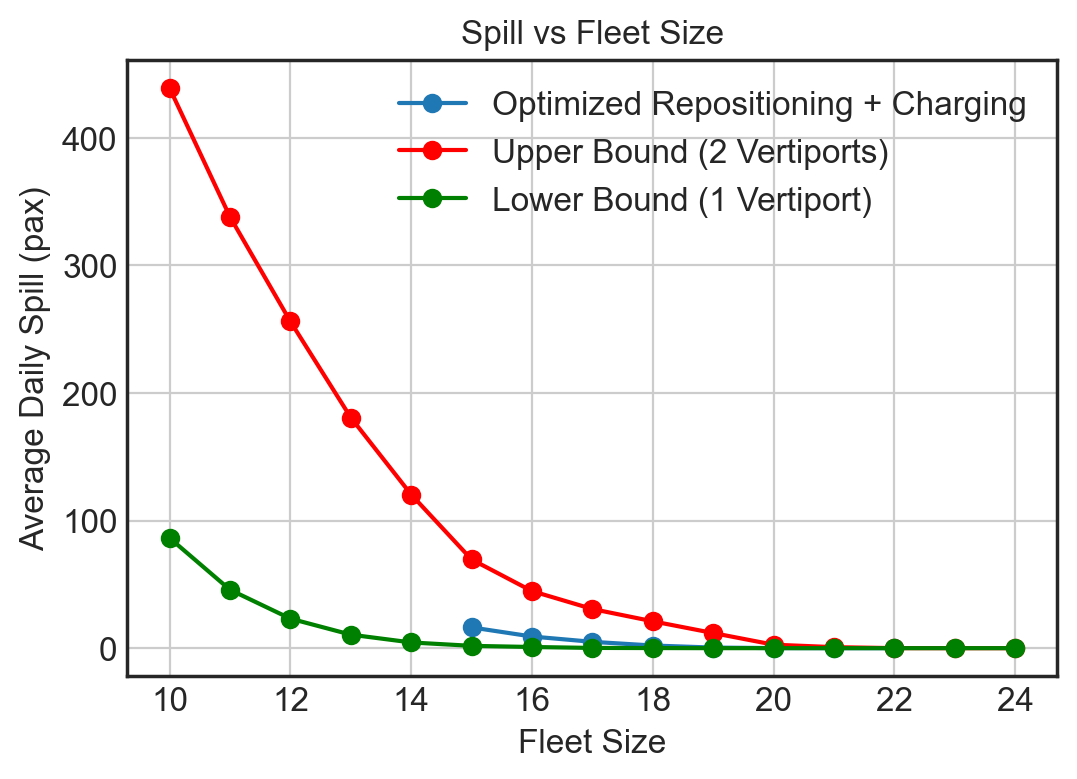

In [111]:
fig, ax = plt.subplots(dpi=200, figsize=(6,4))
ax.plot(np.arange(15,23), y/365, marker='o',
       label='Optimized Repositioning + Charging')
ax.plot(np.arange(10, 25), ub_1500/365, marker='o', color='red', 
       label='Upper Bound (2 Vertiports)')
ax.plot(np.arange(10, 25), lb_1500/365, marker='o', color='green', 
       label='Lower Bound (1 Vertiport)')
ax.set(xlabel='Fleet Size', ylabel='Average Daily Spill (pax)', title='Spill vs Fleet Size')
       # xticks=np.arange(12, 25, 1),
       # xlim=(12, 24))
plt.grid()
plt.legend();

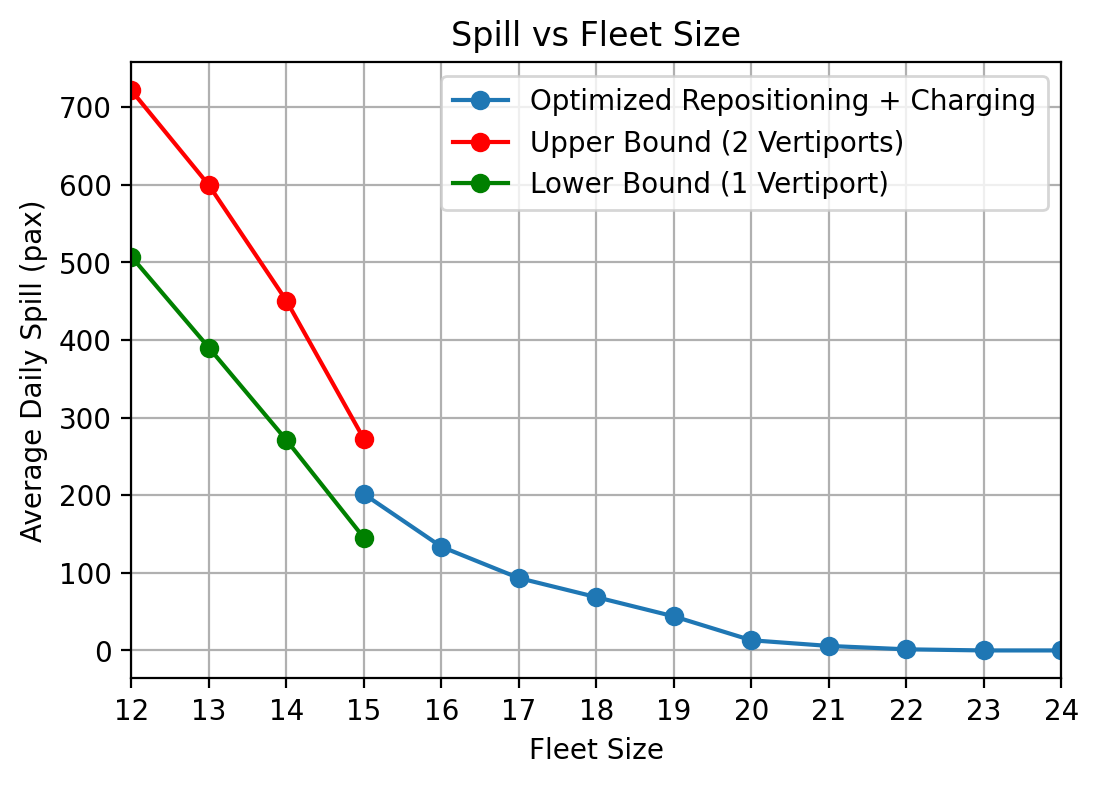

In [62]:
fig, ax = plt.subplots(dpi=200, figsize=(6,4))
ax.plot(x, y/365, marker='o',
       label='Optimized Repositioning + Charging')
ax.plot(np.arange(12, 16), upper_bound/365, marker='o', color='red', 
       label='Upper Bound (2 Vertiports)')
ax.plot(np.arange(12, 16), lower_bound/365, marker='o', color='green', 
       label='Lower Bound (1 Vertiport)')
ax.set(xlabel='Fleet Size', ylabel='Average Daily Spill (pax)', title='Spill vs Fleet Size',
       xticks=np.arange(12, 25, 1),
       xlim=(12, 24))
plt.grid()
plt.legend();

## Get a new demand profile

In [112]:
from UAM_Schedule import UAM_Schedule

In [114]:
sche = UAM_Schedule('DemandUncertainty/LAX_ind.csv', 'DemandUncertainty/T_F41SCHEDULE_B43.csv')
schedule, pax_arrival_times, num_pax = sche.get_one_day(7, 7)

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style ="whitegrid", font_scale=1.5)
import numpy as np

lax_dtla_sche = schedule[schedule['od'] == 'LAX_DTLA']
dtla_lax_sche = schedule[schedule['od'] == 'DTLA_LAX']

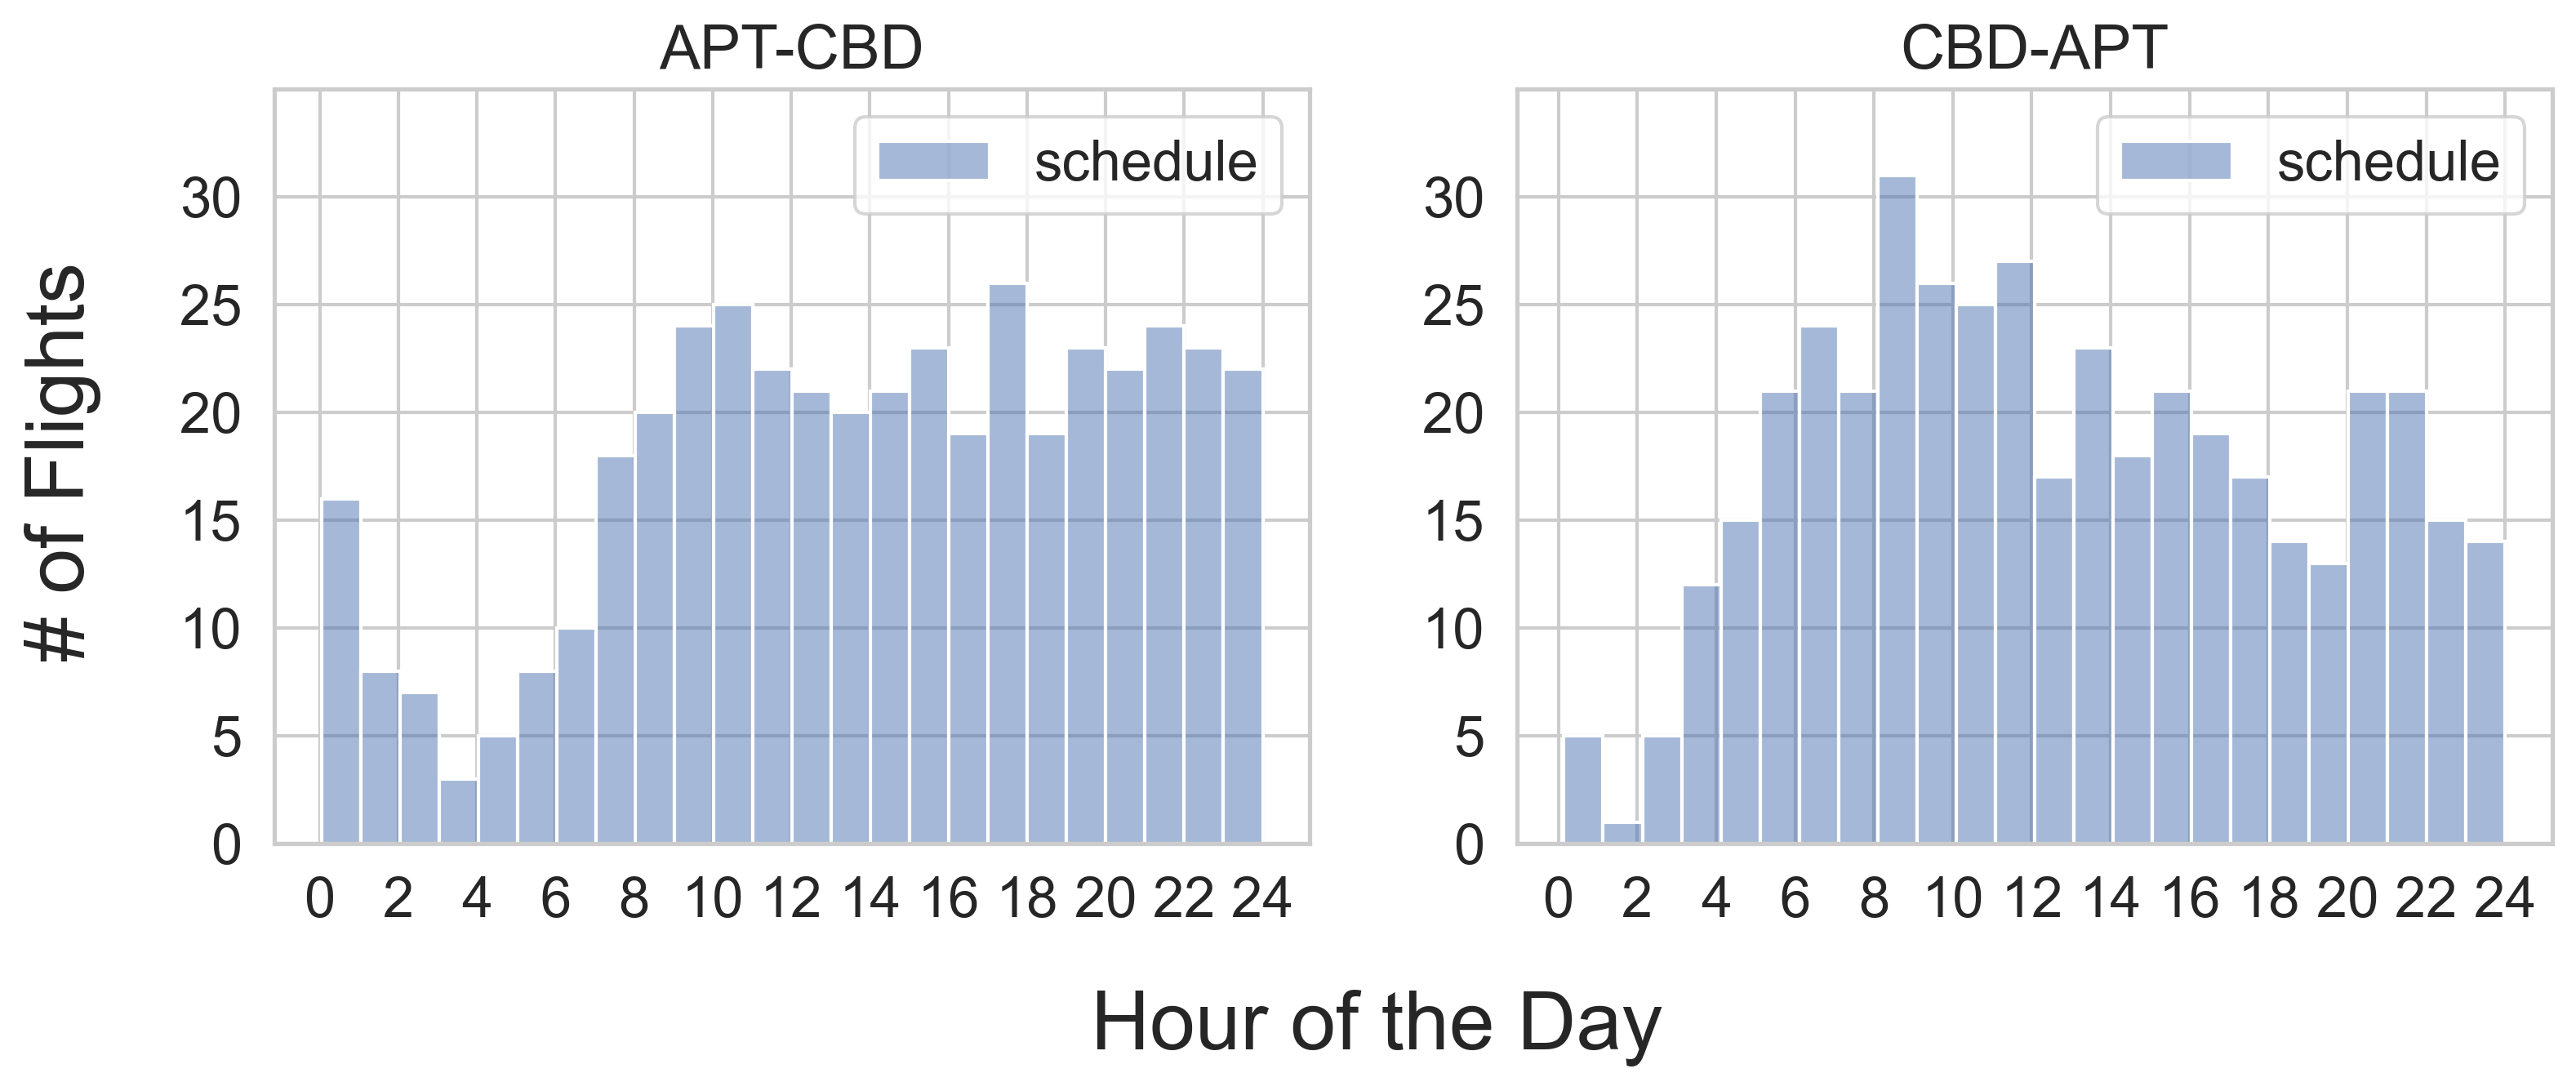

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.histplot(lax_dtla_sche, bins=24, ax=ax[0], label='LAX-DTLA')
sns.histplot(dtla_lax_sche, bins=24, ax=ax[1], label='DTLA-LAX', color='orange')

for i in range(2):
    ax[i].set(xlabel='', ylabel='', 
              xticks=np.arange(0,1560,120), 
              xticklabels=np.arange(0,26,2),
              yticks=np.arange(0,32,5),
              ylim=(0,35))

ax[0].set(title='APT-CBD')
ax[1].set(title='CBD-APT')
fig.text(0.5, -0.1, 'Hour of the Day', ha='center', fontsize=24)
# fig.text(0.5, 1, 'Hourly Scheduled Departures at Vertiports \n (5min threshold)', ha='center', fontsize=24)
fig.text(0.04, 0.5, '# of Flights', va='center', rotation='vertical', fontsize=24)
plt.gcf().set_dpi(300)

In [118]:
schedule.to_csv('input/ICRAT_wind/schedule_1500pax_5min_0205.csv', index=False)
pax_arrival_times.to_csv('input/ICRAT_wind/pax_arrival_times_1500pax_5min_0205.csv', index=False)
num_pax.to_csv('input/ICRAT_wind/num_pax_1500pax_5min_0205.csv', index=False)

In [119]:
from model.op import FleetSizeOptimizer

In [121]:
w = FleetSizeOptimizer(flight_time=np.array([[0, 10],[10, 0]]).astype(int), 
                       energy_consumption=np.array([[0, 10],[10, 0]]).astype(int), 
                       schedule='ICRAT_wind/schedule_1500pax_5min_0205.csv')

In [122]:
w.optimize(output_path=f'ICRAT_wind/0205', verbose=True, optimality_gap=0.05)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-29
Set parameter Threads to value 2
Set parameter MIPGap to value 0.05
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 2 threads

Optimize a model with 21490 rows, 345708 columns and 679870 nonzeros
Model fingerprint: 0x7a1d6634
Variable types: 0 continuous, 345708 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-07, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 2089 rows and 31163 columns
Presolve time: 0.60s
Presolved: 19401 rows, 314545 columns, 643341 nonzeros
Variable types: 0 continuous, 314545 integer (2 binary)
Deterministic concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.35s

Bar

14

In [123]:
w.parse_result('ICRAT_wind/0205_op_result.txt')
w.calculate_aircraft_states()
w.get_summary_statistics(np.array([[0, 10],[10, 0]]).astype(int))

Fleet size: 14.0
Total number of pads: 19; [ 9 10] 
Total number of flights: 1004.0; demand: 854.0; repositioning: 150.0
Total energy consumption: 4016.0 kWh
Total aircraft miles: 10040.0 mi
Total revenue aircraft miles: 8540.0
Ratio of revenue aircraft miles to aircraft miles: 0.850597609561753
